In [ ]:
import pandas as pd
import numpy as np

# 1. Load the CSV
df = pd.read_csv("student_dataset_cleaned.csv", encoding="latin1")

In [ ]:
# 2. Drop Student ID column
if "Student ID" in df.columns:
    df = df.drop(columns=["Student ID"])

In [ ]:
# 3. Strip whitespace from all columns and entries
df.columns = [col.strip() for col in df.columns]
for col in df.columns:
    df[col] = df[col].astype(str).str.strip()

In [ ]:
# 4. Map grade letters to numbers (target)
grade_map = {
    "A+": 4.0, "A": 4.0, "A-": 3.7, "B+": 3.3, "B": 3.0, "B-": 2.7,
    "C+": 2.3, "C": 2.0, "C-": 1.7, "Below C-": 1.0,
    "F": 0, "D": 1.0, "D+": 1.3,
}
df["Subject_Grade_Num"] = df["Subject Grade"].map(grade_map)
df["Subject_Grade_Num"] = df["Subject_Grade_Num"].fillna(df["Subject_Grade_Num"].mean())

In [ ]:
# 5. Map Study Hours per Day to numeric
study_hours_map = {
    "Less than 1 hour": 0.5,
    "1 - 2 hours": 1.5,
    "2 - 4 hours": 3,
    "more than 4 hours": 5,
}
df["Study_Hours_Num"] = df["Study Hours per Day"].map(study_hours_map).fillna(1.5)

In [ ]:
# 6. Map Lecture Attendance to numeric (fraction)
attendance_map = {
    "Always(100%)": 1.0,
    "Often (75 - 99%)": 0.87,
    "Sometimes(50 - 74%)": 0.62,
    "Rarely (25 - 49%)": 0.37,
    "Very rarely (1 - 24%)": 0.12,
    "Never(0%)": 0.0,
}
df["Lecture_Attendance_Num"] = df["Lecture Attendance"].map(attendance_map).fillna(0.5)

In [ ]:
# 7. Map Assignment Completion on Time to numeric (fraction)
assignment_map = {
    "Always (100%)": 1.0,
    "Often (75 - 99%)": 0.87,
    "Sometimes (50 - 74%)": 0.62,
    "Rarely (25 - 49%)": 0.37,
    "Very rarely (1 - 24%)": 0.12,
    "Never(0%)": 0.0,
}
df["Assignment_Completion_Num"] = df["Assignment Completion on Time"].map(assignment_map).fillna(0.5)

In [ ]:
# 8. Map CGPA / GPA to numeric (midpoint for ranges)
gpa_map = {
    "Above 3.5": 3.75,
    "3.0 – 3.5": 3.25,
    "2.5 – 3.0": 2.75,
    "2.0 – 2.5": 2.25,
    "Below 2.0": 1.75,
}
# Handle possible unicode dash variants
df["CGPA / GPA"] = df["CGPA / GPA"].str.replace('–', '-', regex=False)
gpa_map_flexible = {k.replace('–', '-'): v for k, v in gpa_map.items()}
df["GPA_Num"] = df["CGPA / GPA"].map(gpa_map_flexible).fillna(2.5)

In [ ]:
# 9. Encode Note-Taking Method, Study Schedule, Best Study Method with one-hot encoding
onehot_cols = [
    "Note-Taking Method", "Study Schedule", "Best Study Method"
]
df = pd.get_dummies(df, columns=onehot_cols, drop_first=False)

In [ ]:
# 10. Select features and target for modeling
features = [
    "Study_Hours_Num",
    "Lecture_Attendance_Num",
    "Assignment_Completion_Num",
    "GPA_Num"
] + [col for col in df.columns if col.startswith("Note-Taking Method_") or col.startswith("Study Schedule_") or col.startswith("Best Study Method_")]

target = "Subject_Grade_Num"

# 11. Save processed features and target as new CSVs (optional)
df[features].to_csv("student_features_processed.csv", index=False)
df[[target]].to_csv("student_target_processed.csv", index=False)

In [ ]:
# 12. Print shapes as check
print("Features shape:", df[features].shape)
print("Target shape:", df[[target]].shape)

Features shape: (300, 19)
Target shape: (300, 1)


In [ ]:
# Example: use X, y for plugging into your ML pipeline
X = df[features].values
y = df[target].values

In [ ]:
# ----------- 5. SPLIT AND SCALE -----------
# Use the features list from your preprocessing step
X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "scaler.save")
joblib.dump(features, "feature_cols.save")


['feature_cols.save']

In [ ]:
# ----------- 6. BUILD AND TRAIN MODEL -----------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
model.save("student_performance_model.keras")

# Show model summary
model.summary()

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8.5397 - mae: 2.7727 - val_loss: 6.9202 - val_mae: 2.5186
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9342 - mae: 2.2866 - val_loss: 4.3557 - val_mae: 1.9583
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2623 - mae: 1.6342 - val_loss: 1.8216 - val_mae: 1.1897
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1658 - mae: 0.9085 - val_loss: 0.3586 - val_mae: 0.4937
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2462 - mae: 0.4176 - val_loss: 0.2860 - val_mae: 0.4415
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2028 - mae: 0.3701 - val_loss: 0.1359 - val_mae: 0.3063
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0983 - mae: 0.2587 - val_loss: 0.1012 - val_mae: 0.2571
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0840 - mae: 0.2365 - val_loss: 0.0839 - val_mae: 0.2333
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0717 -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,181 (39.77 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,788 (26.52 KB)

In [ ]:
# ----------- 7. EVALUATE -----------
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test_scaled).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0279 - mae: 0.1296 
Test MAE: 0.1247
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Test MAE: 0.1247
Test RMSE: 0.1612
R2 Score: 0.9688


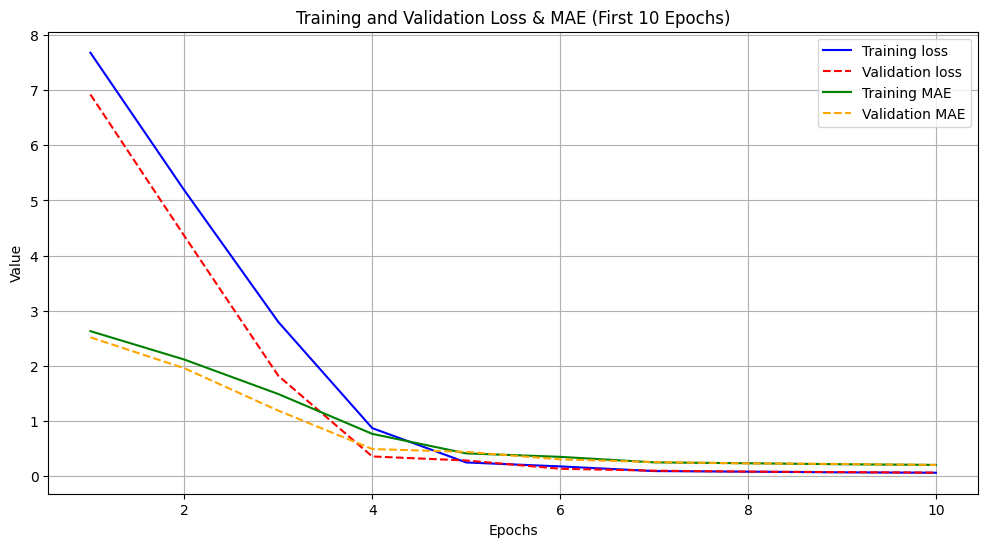

In [ ]:
import matplotlib.pyplot as plt

# Set how many epochs to show
epochs_to_show = 10

# Prepare data for first 10 epochs
epochs = range(1, epochs_to_show + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'][:epochs_to_show], 'b-', label='Training loss')
plt.plot(epochs, history.history['val_loss'][:epochs_to_show], 'r--', label='Validation loss')

# If you have 'mae' and 'val_mae' in your history
if 'mae' in history.history and 'val_mae' in history.history:
    plt.plot(epochs, history.history['mae'][:epochs_to_show], 'g-', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'][:epochs_to_show], color='orange', linestyle='--', label='Validation MAE')

plt.title('Training and Validation Loss & MAE (First 10 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Hyperparameter Tunning

In [ ]:
!pip install keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()
    # Tune the number of units in the first Dense layer
    model.add(Dense(
        units=hp.Int('units1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation1', ['relu', 'tanh']),
        input_shape=(X_train_scaled.shape[1],)
    ))
    # Tune the number of layers and units in the second Dense layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_{i+2}', ['relu', 'tanh'])
        ))
    # Output layer
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=15,  # Increase for more thorough search
    executions_per_trial=1,
    directory='kt_student_model',
    project_name='student_performance'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

# Get the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 00m 11s]
val_mae: 0.12379352003335953

Best val_mae So Far: 0.12112292647361755
Total elapsed time: 00h 03m 02s
Best hyperparameters: {'units1': 224, 'activation1': 'relu', 'num_layers': 1, 'units_2': 32, 'activation_2': 'tanh', 'optimizer': 'rmsprop', 'units_3': 32, 'activation_3': 'tanh', 'units_4': 128, 'activation_4': 'tanh'}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


After HP tunning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 1. Build Model with Best Hyperparameters
model = Sequential()
model.add(Dense(192, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(112, activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Show model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 192)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 112)            │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,769 (120.19 KB)

 Trainable params: 30,769 (120.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 2. Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,  # You can change if a different batch size was best
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.5632 - mae: 2.3842 - val_loss: 0.3116 - val_mae: 0.4566
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4682 - mae: 0.5709 - val_loss: 0.0902 - val_mae: 0.2588
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1097 - mae: 0.2667 - val_loss: 0.0878 - val_mae: 0.2469
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0574 - mae: 0.1991 - val_loss: 0.0752 - val_mae: 0.2207
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0600 - mae: 0.2011 - val_loss: 0.0458 - val_mae: 0.1784
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0386 - mae: 0.1482 - val_loss: 0.0368 - val_mae: 0.1542
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0386 - mae: 0.1452 - val_loss: 0.0331 - val_mae: 0.1462
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0343 - mae: 0.1369 - val_loss: 0.0322 - val_mae: 0.1436
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss

In [ ]:
# 3. Evaluate Model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model.predict(X_test_scaled).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0222 - mae: 0.1204 
Test MAE: 0.1207
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Test MAE: 0.1207
Test RMSE: 0.1500
R2 Score: 0.9730


In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0181 - mae: 0.1017 - val_loss: 0.0248 - val_mae: 0.1313
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178 - mae: 0.1007 - val_loss: 0.0268 - val_mae: 0.1362
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0151 - mae: 0.0959 - val_loss: 0.0262 - val_mae: 0.1286
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - mae: 0.1024 - val_loss: 0.0282 - val_mae: 0.1380
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - mae: 0.1101 - val_loss: 0.0273 - val_mae: 0.1311
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - mae: 0.0880 - val_loss: 0.0259 - val_mae: 0.1267
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - mae: 0.0856 - val_loss: 0.0260 - val_mae: 0.1277
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127 - mae: 0.0834 - val_loss: 0.0241 - val_mae: 0.1171
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

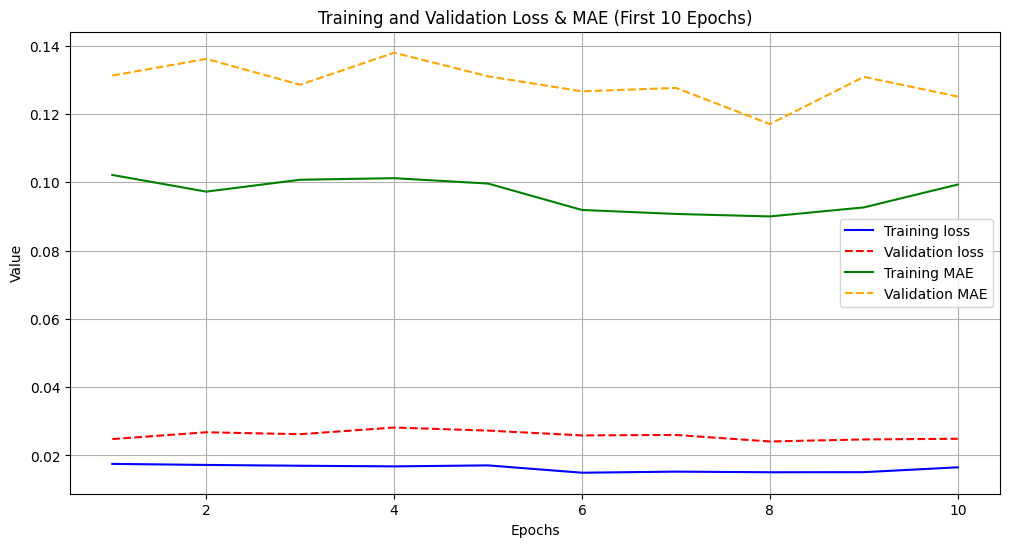

In [ ]:
import matplotlib.pyplot as plt

# Set how many epochs to show
epochs_to_show = 10

# Prepare data for first 10 epochs
epochs = range(1, epochs_to_show + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'][:epochs_to_show], 'b-', label='Training loss')
plt.plot(epochs, history.history['val_loss'][:epochs_to_show], 'r--', label='Validation loss')

# If you have 'mae' and 'val_mae' in your history
if 'mae' in history.history and 'val_mae' in history.history:
    plt.plot(epochs, history.history['mae'][:epochs_to_show], 'g-', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'][:epochs_to_show], color='orange', linestyle='--', label='Validation MAE')

plt.title('Training and Validation Loss & MAE (First 10 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

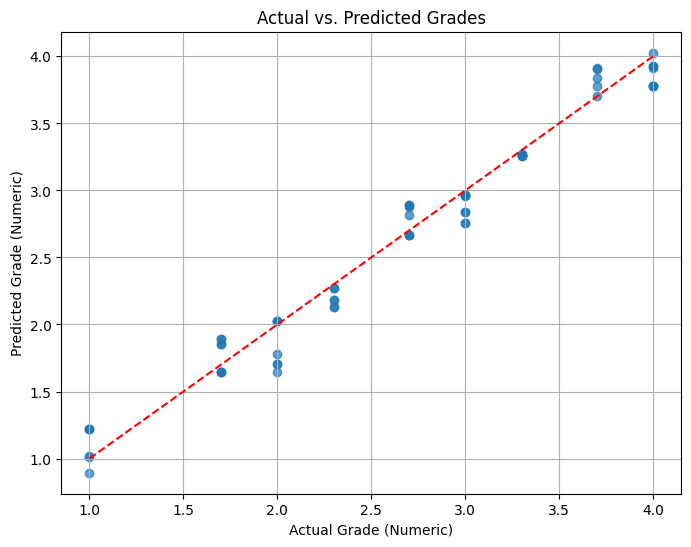

In [ ]:
import matplotlib.pyplot as plt

# y_test: true values, y_pred: model predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Grade (Numeric)')
plt.ylabel('Predicted Grade (Numeric)')
plt.title('Actual vs. Predicted Grades')
plt.grid(True)
plt.show()

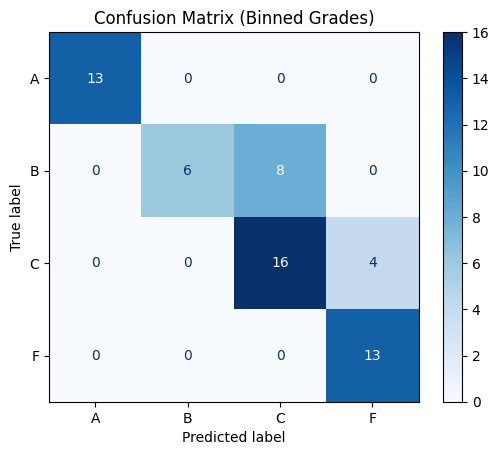

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def num_to_letter_grade(num):
    # Adjust thresholds as appropriate for your institution
    if num >= 3.7:
        return 'A'
    elif num >= 3.0:
        return 'B'
    elif num >= 2.0:
        return 'C'
    else:
        return 'F'

y_test_letter = np.array([num_to_letter_grade(x) for x in y_test.flatten()])
y_pred_letter = np.array([num_to_letter_grade(x) for x in y_pred.flatten()])

cm = confusion_matrix(y_test_letter, y_pred_letter, labels=['A', 'B', 'C', 'F'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C', 'F'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Binned Grades)")
plt.show()

User Input

In [ ]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import pandas as pd # Import pandas to create a DataFrame for the new input

# 1. Define input questions and allowed options
questions = [
    {
        "field": "Study Hours per Day",
        "question": "How many hours do you typically study per day (outside of lectures)?",
        "options": [
            "Less than 1 hour",
            "1 - 2 hours",
            "2 - 4 hours",
            "more than 4 hours"
        ]
    },
    {
        "field": "Lecture Attendance",
        "question": "How frequently do you attend lectures/tutorials?",
        "options": [
            "Always(100%)",
            "Often (75 - 99%)",
            "Sometimes(50 - 74%)",
            "Rarely (25 - 49%)",
            "Very rarely (1 - 24%)",
            "Never(0%)"
        ]
    },
    {
        "field": "Assignment Completion on Time",
        "question": "How often do you complete assignments on time?",
        "options": [
            "Always (100%)",
            "Often (75 - 99%)",
            "Sometimes (50 - 74%)",
            "Rarely (25 - 49%)",
            "Very rarely (1 - 24%)",
            "Never(0%)"
        ]
    },
    {
        "field": "CGPA / GPA",
        "question": "What is your average CGPA or latest semester GPA?",
        "options": [
            "Above 3.5",
            "3.0 – 3.5",
            "2.5 – 3.0",
            "2.0 – 2.5",
            "Below 2.0"
        ]
    },
    {
        "field": "Note-Taking Method",
        "question": "What is your primary note-taking method during studies?",
        "options": [
            "I mostly take my own notes",
            "I mostly rely on class slides",
            "I take notes and refer to slides equally",
            "I rely only on class slides"
        ]
    },
    {
        "field": "Study Schedule",
        "question": "How would you describe your study schedule?",
        "options": [
            "I always follow a fixed study schedule",
            "I usually follow a schedule but adjust it occasionally",
            "I study randomly most of the time",
            "I do not follow any schedule at all"
        ]
    },
    {
        "field": "Best Study Method",
        "question": "What study method works best for you?",
        "options": [
            "Practicing with past papers or questions",
            "Studying alone (self-study)",
            "Using online resources (e.g., YouTube, MOOCs)",
            "Studying in groups",
            "Attending revision classes or extra tutorials",
            "Reading class slides and textbooks only",
            "No specific method – varies each time"
        ]
    }
]

# 2. Encoding maps
study_hours_map = {
    "Less than 1 hour": 0.5,
    "1 - 2 hours": 1.5,
    "2 - 4 hours": 3,
    "more than 4 hours": 5,
}
attendance_map = {
    "Always(100%)": 1.0,
    "Often (75 - 99%)": 0.87,
    "Sometimes(50 - 74%)": 0.62,
    "Rarely (25 - 49%)": 0.37,
    "Very rarely (1 - 24%)": 0.12,
    "Never(0%)": 0.0,
}
assignment_map = {
    "Always (100%)": 1.0,
    "Often (75 - 99%)": 0.87,
    "Sometimes (50 - 74%)": 0.62,
    "Rarely (25 - 49%)": 0.37,
    "Very rarely (1 - 24%)": 0.12,
    "Never(0%)": 0.0,
}

gpa_map = {
    "Above 3.5": 3.75,
    "3.0 – 3.5": 3.25,
    "2.5 – 3.0": 2.75,
    "2.0 – 2.5": 2.25,
    "Below 2.0": 1.75,
}
# Handle possible dash variants
gpa_map_flexible = {k.replace('–', '-'): v for k, v in gpa_map.items()}

# 3. Ask questions interactively
user_answers = {}
for q in questions:
    print('\n' + q["question"])
    for idx, opt in enumerate(q["options"]):
        print(f"{idx+1}. {opt}")
    while True:
        try:
            user_choice = int(input("Enter the number of your choice: ").strip())
            if 1 <= user_choice <= len(q["options"]):
                user_answers[q["field"]] = q["options"][user_choice-1]
                break
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Please enter a number.")

# 4. Load the feature names used during training
feature_cols = joblib.load("feature_cols.save")

# 5. Build input feature vector using a dictionary to ensure correct order and inclusion
input_data = {}

# Add numeric features
input_data["Study_Hours_Num"] = study_hours_map[user_answers["Study Hours per Day"]]
input_data["Lecture_Attendance_Num"] = attendance_map[user_answers["Lecture Attendance"]]
input_data["Assignment_Completion_Num"] = assignment_map[user_answers["Assignment Completion on Time"]]
input_data["GPA_Num"] = gpa_map_flexible.get(user_answers["CGPA / GPA"].replace('–', '-'), 2.5)

# Add one-hot encoded features, ensuring all feature_cols are present with 0 or 1
for col in feature_cols:
    if col.startswith("Note-Taking Method_"):
        option = col.replace("Note-Taking Method_", "")
        input_data[col] = 1.0 if user_answers["Note-Taking Method"] == option else 0.0
    elif col.startswith("Study Schedule_"):
        option = col.replace("Study Schedule_", "")
        input_data[col] = 1.0 if user_answers["Study Schedule"] == option else 0.0
    elif col.startswith("Best Study Method_"):
        option = col.replace("Best Study Method_", "")
        # Handle the unicode dash in "No specific method – varies each time"
        if "No specific method – varies each time" in option:
             option = option.replace('–', '-')
             user_answer_cleaned = user_answers["Best Study Method"].replace('–', '-')
             input_data[col] = 1.0 if user_answer_cleaned == option else 0.0
        else:
             input_data[col] = 1.0 if user_answers["Best Study Method"] == option else 0.0
    # Ensure numeric columns are in the dictionary even if they are already added
    elif col not in input_data:
         # This case should ideally not be reached if the initial numeric features are added correctly
         # but is included for robustness. You might need to handle other engineered features here as well
         pass


# Create a DataFrame from the input data, ensuring columns are in the same order as feature_cols
X_new_df = pd.DataFrame([input_data])[feature_cols]

# Convert to numpy array for scaling and prediction
X_new = X_new_df.values.astype(np.float32)


# 6. Load scaler and model
scaler = joblib.load("scaler.save")
X_new_scaled = scaler.transform(X_new)
model = load_model("student_performance_model.keras")

# 7. Predict
pred_grade = model.predict(X_new_scaled)[0,0]
def num_to_grade(num):
    if num >= 3.85:
        return "A+"
    elif num >= 3.7:
        return "A"
    elif num >= 3.3:
        return "A-"
    elif num >= 3.0:
        return "B+"
    elif num >= 2.7:
        return "B"
    elif num >= 2.3:
        return "C+"
    elif num >= 2.0:
        return "C"
    elif num >= 1.7:
        return "C-"
    elif num >= 1.3:
        return "D+"
    elif num >= 1.0:
        return "D" # Changed D to 1.0 in grade_map, so this should align.
    else:
        return "F"

pred_letter = num_to_grade(pred_grade)

print("\n--- Prediction Result ---")
print(f"Predicted Grade (numeric): {pred_grade:.2f}")
print(f"Predicted Grade (letter): {pred_letter}")

# 8. Motivation message
if pred_grade >= 3.7:
    message = "Excellent work! Keep up your great study habits and motivation!"
elif pred_grade >= 3.0:
    message = "Very good! You're on track for strong academic success. Keep pushing yourself a little more!"
elif pred_grade >= 2.0:
    message = "You're doing okay, but with more consistency and effort, you can achieve even better results!"
else:
    message = "Don't be discouraged! Every student can improve. Try to focus on regular habits and ask for help when needed."

print(f"\nMotivation: {message}")


How many hours do you typically study per day (outside of lectures)?
1. Less than 1 hour
2. 1 - 2 hours
3. 2 - 4 hours
4. more than 4 hours
Enter the number of your choice: 4

How frequently do you attend lectures/tutorials?
1. Always(100%)
2. Often (75 - 99%)
3. Sometimes(50 - 74%)
4. Rarely (25 - 49%)
5. Very rarely (1 - 24%)
6. Never(0%)
Enter the number of your choice: 2

How often do you complete assignments on time?
1. Always (100%)
2. Often (75 - 99%)
3. Sometimes (50 - 74%)
4. Rarely (25 - 49%)
5. Very rarely (1 - 24%)
6. Never(0%)
Enter the number of your choice: 2

What is your average CGPA or latest semester GPA?
1. Above 3.5
2. 3.0 – 3.5
3. 2.5 – 3.0
4. 2.0 – 2.5
5. Below 2.0
Enter the number of your choice: 5

What is your primary note-taking method during studies?
1. I mostly take my own notes
2. I mostly rely on class slides
3. I take notes and refer to slides equally
4. I rely only on class slides
Enter the number of your choice: 3

How would you describe your study sc